## Import libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import joblib as jl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
import scikitplot as skplt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

## Import Dataset

In [7]:
dataset = pd.read_csv('Data/dogs_intakes_outcomes_clean.csv')



# Check for null values in important features

In [8]:
# dataset.apply(lambda x: sum(x.isnull()/len(dataset)))

## Setting dependent and independent variable categories

In [9]:
dataset =  dataset.loc[(dataset['outcome_type'] == 'Adoption')                                  
                                 | (dataset['outcome_type'] == 'Transfer')
                                 | (dataset['outcome_type'] == 'Return to Owner')
                                 | (dataset['outcome_type'] == 'Euthanasia')]


# dataset = dataset.sample(frac=0.01, replace=True, random_state=1)

In [10]:
x = dataset.filter(items=['sex', 'spay/neuter', 'mixed_breed', 'time_in_shelter_days_12',
                         'coat', 'intake_hour', 'intake_weekday', 'intake_month', 'age_upon_outcome_(years)',
                         'intake_condition_clean', 'intake_type', 'Puppy/Dog_intake', 'Bully_breed'])

In [11]:
for col in x:
    x[col] = x[col].astype('category')
y = dataset['outcome_type'].astype('category')



In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
print(x.head(1))
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False, handle_unknown = "ignore"), 
                                      [*range(0, 13, 1)])], remainder='passthrough')
xarr = np.array(ct.fit_transform(x))
print(xarr[0])

    sex spay/neuter mixed_breed time_in_shelter_days_12    coat intake_hour  \
0  Male         Yes       Mixed            (0.21, 1.04]  yellow          14   

  intake_weekday intake_month age_upon_outcome_(years) intake_condition_clean  \
0       Thursday           12                     10.0                 Normal   

  intake_type Puppy/Dog_intake Bully_breed  
0       Stray              Dog   Not Bully  
[0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


In [13]:
yarr, ynames = pd.factorize(dataset['outcome_type'])
print(yarr[0:10])

[0 0 0 1 0 0 0 0 0 0]


# Split x and y arrays into training and testing sets

In [14]:


x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)
y_df = pd.Series(y_train,
              name="outcome_type")
y_df = y_df.to_frame()
y_df.loc[y_df['outcome_type'] == 0, 'outcome_type'] = 'Return to Owner'
y_df.loc[y_df['outcome_type'] == 1, 'outcome_type'] = 'Transfer'
y_df.loc[y_df['outcome_type'] == 2, 'outcome_type'] = 'Adoption'
y_df.loc[y_df['outcome_type'] == 3, 'outcome_type'] = 'Euthanasia'
print(y_df)

          outcome_type
0      Return to Owner
1             Adoption
2             Adoption
3             Adoption
4             Adoption
...                ...
31460         Transfer
31461         Transfer
31462         Adoption
31463         Adoption
31464         Transfer

[31465 rows x 1 columns]


# Use PCA to reduce dimensions

In [12]:
pca = PCA(n_components = 5).fit(x_train)
components = pca.transform(x_train)
print(pca.explained_variance_ratio_)

[0.08369223 0.06559536 0.05836029 0.04270528 0.03626921]


In [13]:
# col = y.outcome_type.map({0:'Adoption', 1:'Transfer', 2:'Return to Owner', 3:'Euthanasia'})
print(dataset['outcome_type'])

33157           Transfer
12224           Adoption
5219            Adoption
32662           Transfer
44012           Transfer
              ...       
3011     Return to Owner
35831           Transfer
42903           Adoption
34654           Adoption
13496    Return to Owner
Name: outcome_type, Length: 450, dtype: object


In [41]:
import plotly.express as px



total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_df['outcome_type'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

ValueError: All arguments should have the same length. The length of argument `color` is 31465, whereas the length of  previously-processed arguments ['0', '1', '2'] is 315

ValueError: 'c' argument has 31465 elements, which is inconsistent with 'x' and 'y' with size 315.

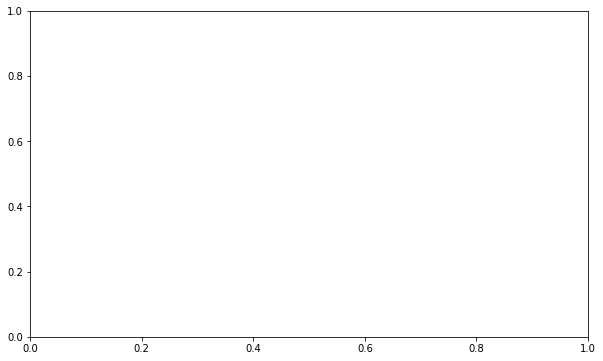

In [42]:
plt.figure(figsize=(10,6))

plt.scatter(components[:,0],components[:,1], c=y_train)

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

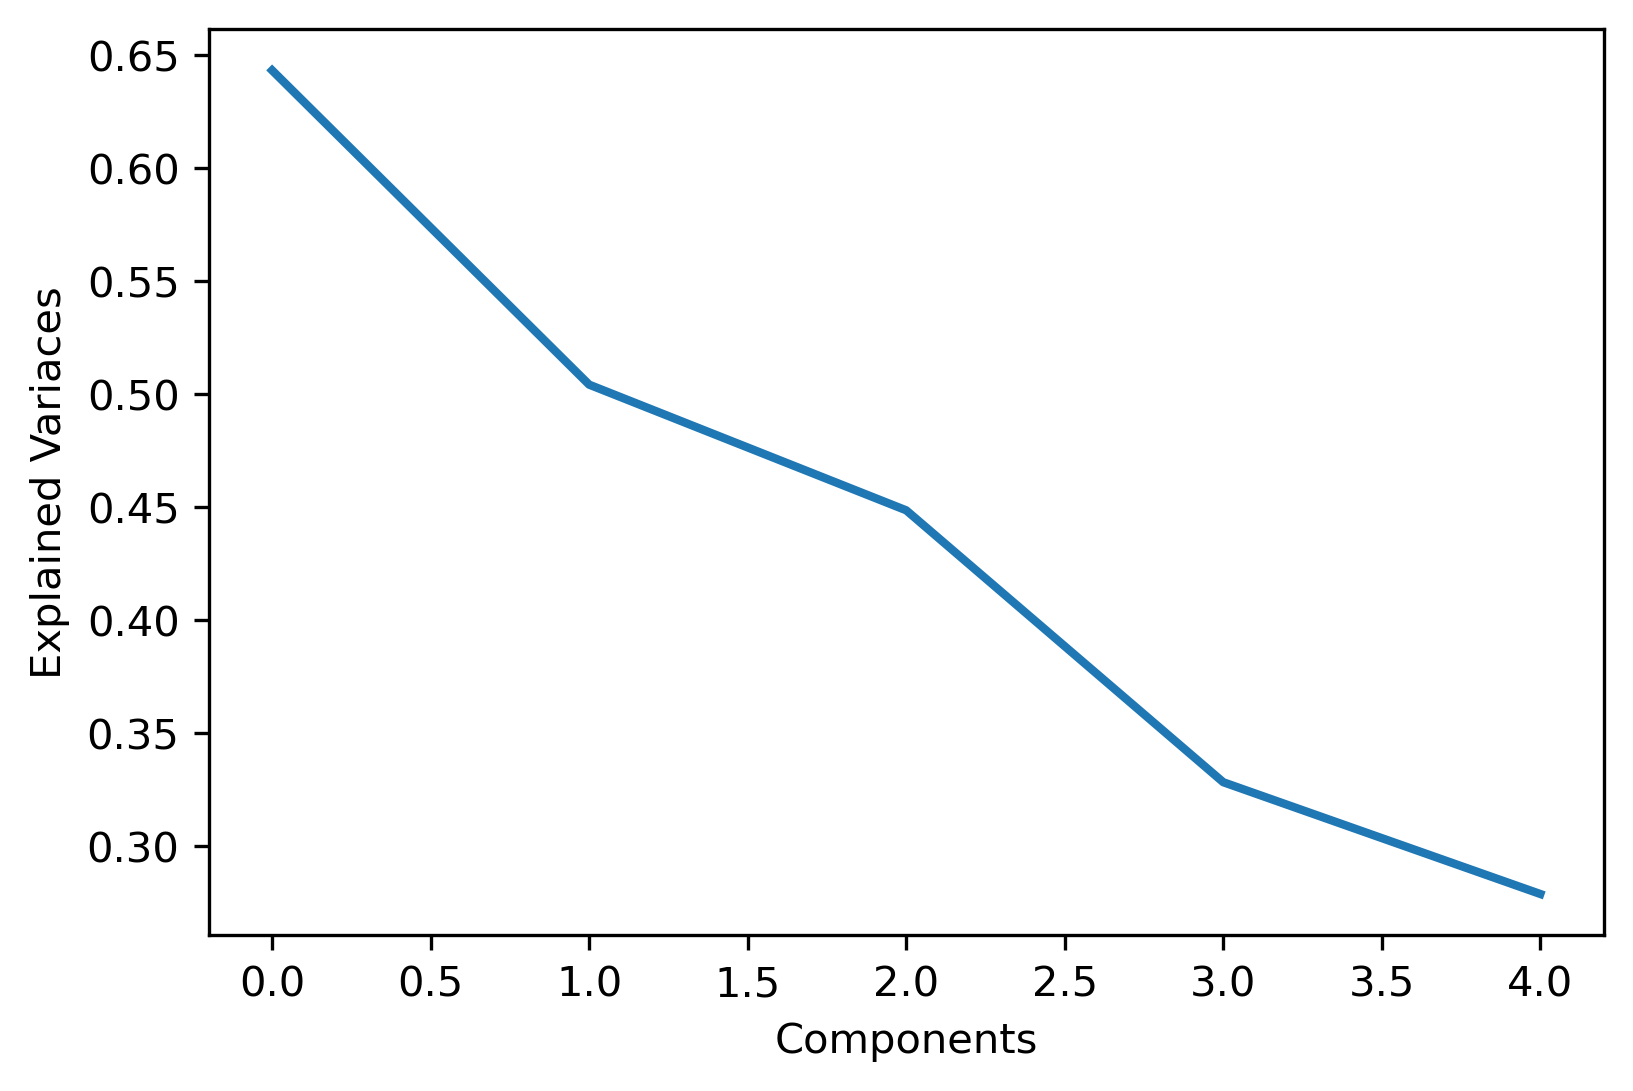

In [43]:
from matplotlib.pyplot import figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import show

figure(1, figsize=(6,4), dpi=300)
plot(pca.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variaces')
show()

# Chain kbest feature extration to PCA with feature union

In [15]:
feature_union = FeatureUnion([
    ('pca', PCA(n_components = 60)),
    ('kbest', SelectKBest(k=4))
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=50, criterion='entropy', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])


prediction_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=60,
                                                     random_state=None,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('kbest',
                                                 SelectKBest(k=4,
                                                             score_func=<function f_classif at 0x000002332AA77828>))],
                              transformer_weights=None, verbose=False)),
                ('rf',
                 RandomForestClassifier(bootstrap=True,
                  

##### import warnings
warnings.simplefilter('ignore')

prediction_model.fit(x_train_scaled, y_train)

# Test prediction with StratifiedKFold

In [16]:
from sklearn.metrics import accuracy_score, classification_report

import warnings

warnings.simplefilter('ignore')

cv = StratifiedKFold(4)
cv_score = cross_val_score(prediction_model, x_train, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train, y_train, cv=cv)



## Print cv_score, mean of cv_score, and accuracy score of predictions for test data

In [17]:
print(cv_score)
print(np.mean(cv_score))
print(accuracy_score(y_train, cv_predict_score))

[0.74745806 0.74307145 0.74294432 0.75727908]
0.7476882266389727
0.7476243445097728


In [18]:
rf_pred = prediction_model.predict(x_test)

In [19]:
print(accuracy_score(y_test, rf_pred))

0.7507044342280884


## Visualize a decision tree from the model

In [23]:
from sklearn import tree

fn=x.columns
cn=y_df.outcome_type.unique()
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10), dpi=800)
tree.plot_tree(prediction_model['rf'].estimators_[0],
                class_names=cn,
                filled = True);
fig.savefig('rf_individualtree.png')

## Show confusion matrix for model

Confusion matrix, without normalization
[[3322   88  522   35]
 [ 276  709 1828   46]
 [ 173  263 5760   13]
 [  35   63   20  333]]
Normalized confusion matrix
[[0.84 0.02 0.13 0.01]
 [0.1  0.25 0.64 0.02]
 [0.03 0.04 0.93 0.  ]
 [0.08 0.14 0.04 0.74]]


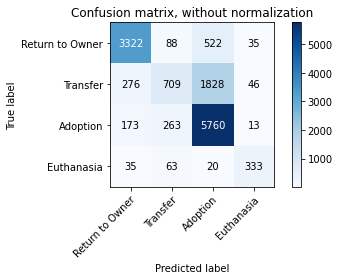

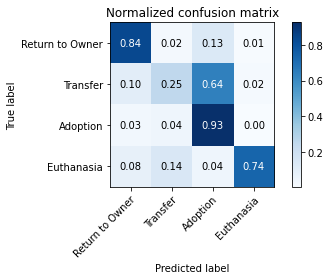

In [20]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ynames
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Parameter tuning

In [45]:
criterion = ['entropy']
components = [60]
estimators = [30, 50, 100, 200, 300]
k = [4]



In [46]:
from sklearn.multiclass import OneVsRestClassifier

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model_tune = Pipeline([
    ('feature_union', feature_union),
    ('rf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample', 
                                                      bootstrap=True, oob_score=True)))
])

rf_gridcv = GridSearchCV(prediction_model_tune, dict(feature_union__pca__n_components=components, 
                                                     feature_union__kbest__k=k, 
                                                     rf__estimator__n_estimators=estimators, 
                                                     rf__estimator__criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

In [47]:
rf_gridcv.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pca',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            n_components=None,
                                                                            random_state=None,
                                                                            svd_solver='auto',
                                                                            tol=0.0,
                                                                        

# Save grid_models

In [48]:
jl.dump(rf_gridcv, 'Data/rfg4outcomes.pkl') 

['Data/rfg4outcomes.pkl']

# Convert grid to pandas dataframa

In [49]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_union__kbest__k,param_feature_union__pca__n_components,param_rf__estimator__criterion,param_rf__estimator__n_estimators,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
27,23.943778,0.142117,0.193433,0.015727,5,60,entropy,30,"{'feature_union__kbest__k': 5, 'feature_union_...",0.746314,...,0.759186,0.750040,0.005312,1,0.998262,0.998178,0.998347,0.998814,0.998400,0.000246
23,24.805243,0.300820,0.194505,0.014251,4,65,entropy,30,"{'feature_union__kbest__k': 4, 'feature_union_...",0.750635,...,0.759313,0.749913,0.006016,2,0.998347,0.998178,0.998644,0.998898,0.998517,0.000276
17,21.481156,0.070523,0.191106,0.011972,3,60,entropy,30,"{'feature_union__kbest__k': 3, 'feature_union_...",0.747458,...,0.759313,0.749881,0.005523,3,0.998262,0.998220,0.998008,0.998771,0.998316,0.000280
28,24.597298,0.492425,0.184987,0.015236,5,65,entropy,30,"{'feature_union__kbest__k': 5, 'feature_union_...",0.748221,...,0.758805,0.749849,0.005280,4,0.998093,0.997966,0.998136,0.998686,0.998220,0.000276
22,24.092981,0.237096,0.197806,0.006459,4,60,entropy,30,"{'feature_union__kbest__k': 4, 'feature_union_...",0.750000,...,0.757661,0.749436,0.005205,5,0.998347,0.997712,0.998178,0.998771,0.998252,0.000379


In [22]:
sns.set(font_scale=1.1)

rf_grid_pred = rf_gridcv.predict(x_test)
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)

plt.figure(figsize=(12, 12))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, rf_grid_pred, classes=ynames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rf_grid_pred, classes=ynames, normalize=True,
                      title='Normalized confusion matrix')

NameError: name 'plot_confusion_matrix' is not defined

<Figure size 864x864 with 0 Axes>

In [ ]:
print(accuracy_score(y_test, rf_grid_pred))

## Make single prediction

In [ ]:


new_pred = [['Female', 'Yes', 'Purebred', 3, 'tricolor', 3, 'Wednesday', 12,
                            2017, 3, 'Normal', 'Stray', 'Dog', 'Not Bully']]



x = dataset.filter(items=['sex', 'spay/neuter', 'mixed_breed', 'time_in_shelter_days_12',
                         'coat', 'intake_hour', 'intake_weekday', 'intake_month', 'intake_year', 'age_upon_intake_age_group',
                         'intake_condition_clean', 'intake_type', 'Puppy/Dog_intake', 'Bully_breed'])
for col in x:
    x[col] = x[col].astype('category')
    



df_single = pd.DataFrame(new_pred,columns=x.columns)
for col in df_single:
    df_single[col] = df_single[col].astype('category')
print(np.array(df_single))
pred_single = ct.transform(df_single)
print(pred_single)


In [ ]:
print(prediction_model.predict(pred_single))

# Save primary model

## Model

In [95]:
jl.dump(prediction_model, 'Data/primary_model.pkl', compress=3) 

['Data/primary_model.pkl']

## Transformer/One Hot Encoder

In [82]:
jl.dump(ct, 'Data/primary_ct.pkl') 

['Data/primary_ct.pkl']

In [62]:
jl.dump(x.columns, 'Data/columns.pkl') 

['Data/columns.pkl']

In [30]:
tree.export_graphviz(prediction_model['rf'].estimators_[0],
                     out_file="tree.dot",

                     class_names=cn,
                     filled = True)

## Visuzalize PCA with 3 principle components

In [31]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(prediction_model['rf'].estimators_[0], out_file=None, 
                                  
                                class_names=cn,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Compare memory size of models

In [3]:
dataset = pd.read_csv('Data/modelsize.csv')
print(dataset.columns)

Index(['index', 'estimators', 'cv_score', 'size'], dtype='object')


Text(0, 0.5, 'cv_score')

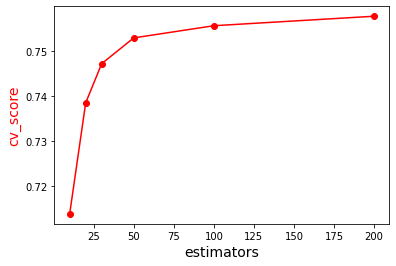

In [4]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(dataset.estimators, dataset.cv_score, color="red", marker="o")
# set x-axis label
ax.set_xlabel("estimators",fontsize=14)
# set y-axis label
ax.set_ylabel("cv_score",color="red",fontsize=14)

In [5]:
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dataset.estimators, dataset["size"],color="blue",marker="o")
ax2.set_ylabel("size(kilobytes)",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')